# imports

In [1]:
import os
import torch
import json
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import nltk
import matplotlib.pyplot as plt
import random
import spacy
from torch.nn.utils.rnn import pad_sequence

# set the device

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# set hyperparameters

In [3]:
#TODO

# Collate

In [5]:
class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets

# Vocabulary

In [71]:
# TODO: complete it

# Download with: python -m spacy download en
spacy_eng = spacy.load("en_core_web_sm")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<pad>", 1: "<start>", 2: "<end>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<start>": 1, "<end>": 2, "<unk>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    # def build_vocabulary(self, sentence_list):
    #     frequencies = {}
    #     idx = 4

    #     for sentence in sentence_list:
    #         for word in self.tokenizer_eng(sentence):
    #             if word not in frequencies:
    #                 frequencies[word] = 1

    #             else:
    #                 frequencies[word] += 1

    #             if frequencies[word] == self.freq_threshold:
    #                 self.stoi[word] = idx
    #                 self.itos[idx] = word
    #                 idx += 1

    def build_vocabulary(self, tokens):
        frequencies = Counter()

        for cap_tokens in tokens:
            # Update word frequency
            frequencies.update(cap_tokens)

        words = [w for w in frequencies.keys() if frequencies[w] > self.freq_threshold]
        self.stoi.update({k: v + 4 for v, k in enumerate(words)})
        self.itos.update({v + 4: k for v, k in enumerate(words)})

    def numericalize(self, text, tokenized_text):
        you can use tokens from 
        # tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

    def textualize(self, embedding):
        embedding_list = embedding.tolist()
        return " ".join(self.itos[num] for num in embedding_list)

# load data

In [72]:
class ImageCaptionDataset(Dataset):
    def __init__(self, image_folder, captions_dict, tokens, captions_per_image=5, transform=None, freq_threshold=5):
        self.image_folder = image_folder
        self.captions_per_image = captions_per_image
        self.captions_dict = self.sample_captions(captions_dict)  # Dictionary with {image_name: [caption1, caption2, ...]}
        self.tokens = tokens
        self.captions = [caption for captions in captions_dict.values() for caption in captions] # all captions together
        self.caption_lengths = [len(caption.split()) for caption in self.captions]
        self.image_names = list(captions_dict.keys())  # List of unique image names
        self.transform = transform
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        # self.vocab.build_vocabulary(self.captions)
        self.vocab.build_vocabulary(self.tokens)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, image_name)

        # Open image
        image = Image.open(image_path).convert("RGB")


        # # If the image is grayscale (2D array: height × width), it lacks a channel dimension
        # if len(img.shape) == 2:
        #     # Add a new axis to make it (height, width, 1)
        #     img = img[:, :, np.newaxis]
        #     # Duplicate the single channel 3 times to mimic RGB (now (height, width, 3))
        #     img = np.concatenate([img, img, img], axis=2)
        # img = np.resize(img, (256, 256, 3))
        # # Convert the image from (H, W, C) (height, width, channels) to (C, H, W).
        # img = img.transpose(2, 0, 1)


        
        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Get all captions for the image
        captions = self.captions_dict[image_name]

        random_idx = random.randrange(len(captions))
        caption = captions[random_idx]
        
        numericalized_caption = [self.vocab.stoi["<start>"]]
        numericalized_caption += self.vocab.numericalize(caption, self.tokens[idx * self.captions_per_image + random_idx])
        numericalized_caption.append(self.vocab.stoi["<end>"])
        numericalized_caption = torch.tensor(numericalized_caption)


        # # Return NON-PADDED captions and their lengths
        # caption = torch.LongTensor(captions[idx])  # Shape: (actual_length,)
        # caplen = torch.LongTensor([caption_lengths[idx]])
        

        return image, numericalized_caption

    def sample_captions(self, img_captions):
        modified_captions_dict = {}
        for img, captions in img_captions.items():
            if len(captions) < self.captions_per_image:
                new_captions = captions + [random.choice(captions) for _ in range(self.captions_per_image - len(captions))]
            else:
                new_captions = random.sample(captions, k=self.captions_per_image)
            # Sanity check
            assert len(new_captions) == self.captions_per_image
            modified_captions_dict[img] = new_captions        
            
        return modified_captions_dict

In [24]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pre-trained models
])

# image_folder = "/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/"  
image_folder = "/kaggle/input/flickr8kimagescaptions/flickr8k/images/"
# karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr30k.json" 
karpathy_json_path = "/kaggle/input/karpathy-splits/dataset_flickr8k.json"

In [25]:
# Load Karpathy split JSON
with open(karpathy_json_path, "r") as f:
    data = json.load(f)

# Organize images by split
split_data = {"train": {}, "val": {}, "test": {}}
token_data = {"train": [], "val": [], "test": []}

for img in data["images"]:
    image_name = img["filename"]
    split = img["split"]  # Can be "train", "val", or "test"
    
    captions = [sent["raw"] for sent in img["sentences"]]  # Extract all 5 captions
    split_data[split][image_name] = captions  # Store in respective split
    
    tokens = [sent["tokens"] for sent in img["sentences"]]  # Extract all tokens
    token_data[split] += tokens

# Now we have:
# split_data["train"], split_data["val"], split_data["test"]


In [73]:
# Load different splits
train_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["train"], 
    token_data["train"], 
    captions_per_image=5,
    transform=transform, 
    freq_threshold=5
)
val_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["val"], 
    token_data["val"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=5
)
test_dataset = ImageCaptionDataset(
    image_folder, 
    split_data["test"], 
    token_data["test"], 
    captions_per_image=5,
    transform=transform,
    freq_threshold=5
)

pad_idx = train_dataset.vocab.stoi["<pad>"]
# Create DataLoaders
train_loader = DataLoader(train_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, collate_fn=MyCollate(pad_idx=pad_idx), batch_size=4, shuffle=False)

# visualize data

In [11]:
# Test the dataloader
# Fetch one batch
images, captions = next(iter(train_loader))

print(f"Batch Size: {len(images)}")
print(f"Image Tensor Shape: {images.shape}")  # Should be [batch_size, 3, 224, 224]
print(f"First Caption: {captions[0]}")

Batch Size: 4
Image Tensor Shape: torch.Size([4, 3, 256, 256])
First Caption: tensor([1, 1, 1, 1])


In [12]:
def get_all_caps(dataset, idx):
    image_name = dataset.image_names[idx]
    return dataset.captions_dict[image_name]

['man', 'on', 'an', 'atv', 'catching', 'air']


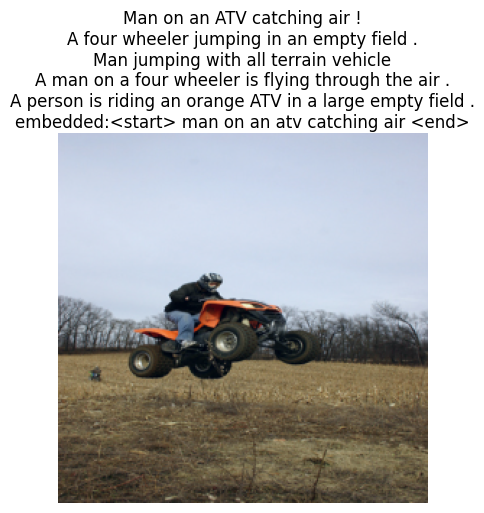

In [76]:
# Visualize a sample
def show_sample(dataset, idx):
    image, caption = dataset[idx]
    image = image.permute(1, 2, 0).numpy()
    image = image * 0.225 + 0.45  # De-normalize
    # wrapped_caption = "\n".join(caption)
    text_caption = str(caption)
    text_caption = dataset.vocab.textualize(caption)
    all_caps = "\n".join(get_all_caps(dataset, idx))
    plt.imshow(image)
    plt.title(all_caps + '\nembedded:' + text_caption, fontsize=12, wrap=True)
    plt.axis('off')
    plt.show()

show_sample(train_dataset, random.randint(0, len(train_dataset)))

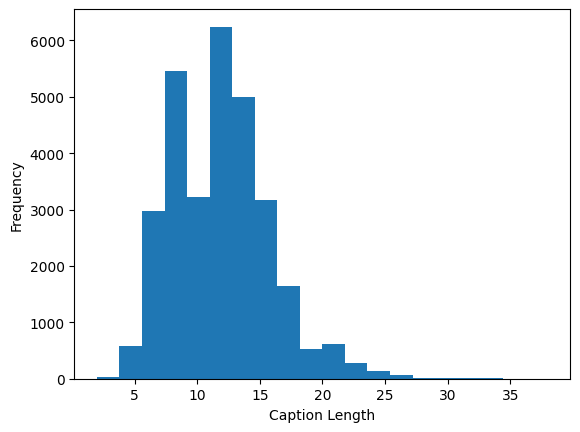

In [90]:
# Caption Length Analysis
caption_lengths = train_dataset.caption_lengths
plt.hist(caption_lengths, bins=20)
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.show()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


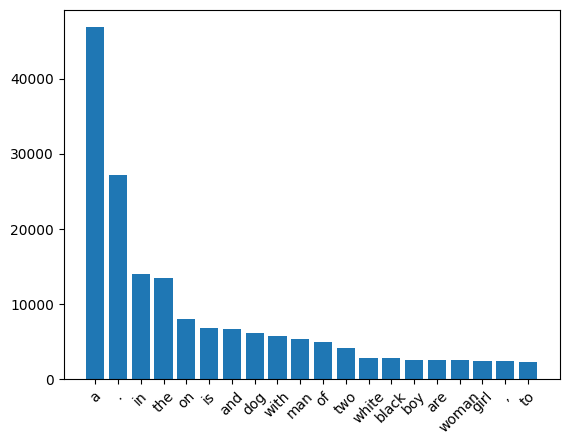

In [91]:
# Word Frequency
all_captions = [caption for caption in train_dataset.captions]

nltk.download('punkt')
all_words = nltk.tokenize.word_tokenize(" ".join(all_captions).lower())
word_freq = Counter(all_words)

# Plot top 20 words
plt.bar(*zip(*word_freq.most_common(20)))
plt.xticks(rotation=45)
plt.show()

# model

# train

# validate

# test on new data

# TTS

# Save outputs for next time

In [ ]:
!zip -r saved_data.zip /kaggle/working/